#### Imports and Data Collection

In [129]:
!pip install pandas_datareader

In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 


In [2]:
#Defining some constants for data mining


NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'IAK'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close  volume
Date                                                                     
2006-05-05  50.099998  50.250000  50.099998  50.250000  38.153019     600
2006-05-08  50.299999  50.349998  50.230000  50.230000  38.137840    1800
2006-05-09  50.209999  50.310001  50.200001  50.250000  38.153019     800
2006-05-10  50.250000  50.250000  50.250000  50.250000  38.153019       0
2006-05-11  50.250000  50.250000  49.790001  49.790001  37.803753    3000


<AxesSubplot:xlabel='Date'>

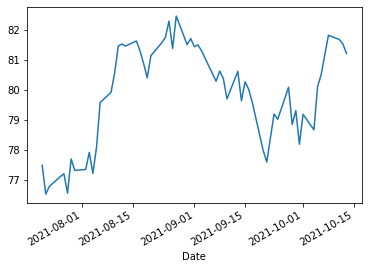

In [3]:
#Next we pull the historical data using yfinance
#Rename the column names because finta uses the lowercase names


start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

#### Data Processing

<AxesSubplot:xlabel='Date'>

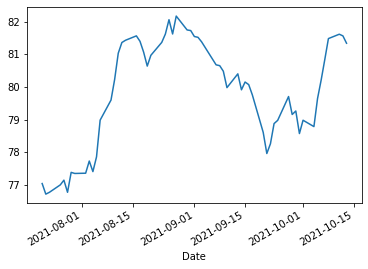

In [4]:
#Next we clean our data and perform feature engineering to create new technical indicator features that our
#model can learn from


def exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

Having many peaks and troughs can make it hard to approximate, or be difficult to extract tends when computing the technical indicators. It can throw the model off.

In [89]:
def get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del(data['open'])
    del(data['high'])
    del(data['low'])
    del(data['volume'])
    del(data['Adj Close'])
    
    return data

data = get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [90]:
live_pred_data = data.iloc[-16:-11]

In [91]:
def produce_prediction(data, window):
   
    #Function that produces the 'truth' values
    #At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    #:param window: number of days, or rows to look ahead to see what the price did
    
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2021-09-13,51.004689,0.823611,0.959203,23.188629,7.398792e+06,1.429857,-0.175568,59.082193,0.067041,8.781792e+06,0.220633,-0.040587,0.906036,1.002362,1.036062,1.016472,1.005619,0.984834,0.786381,0.0
2021-09-14,50.635890,0.701322,0.907627,19.953329,7.273033e+06,1.453183,-0.730948,59.372644,1.237290,8.437970e+06,1.846142,-0.049048,0.908617,0.997925,1.034043,1.014483,1.004053,0.986283,0.815710,0.0
2021-09-15,50.539415,0.596307,0.845363,19.653622,7.350802e+06,1.428383,-0.723833,53.584822,-0.515368,8.071868e+06,-15.805164,-0.210329,0.962020,0.976593,1.033038,1.013514,1.003490,0.988286,0.888023,0.0
2021-09-16,49.675270,0.496959,0.775682,16.273437,7.462050e+06,1.411067,-1.345342,53.861485,-1.766369,7.768752e+06,-35.195037,-0.209411,0.959978,0.972577,1.029699,1.010340,1.000785,0.988035,0.769183,0.0
2021-09-17,48.905687,0.404677,0.701481,10.609470,7.605449e+06,1.349895,-2.108867,48.531445,-1.944446,7.434251e+06,-55.028048,-0.301432,0.991638,0.970349,1.026818,1.007686,0.998619,0.988139,0.870764,0.0


#### Model Creation

Due to the nature of time-series, if we randomize our train-test set we could encounter a look-ahead bias which is not good for predicting the stock market. To prevent this cross-validation will be used to train the model.

##### Random Forest

In [14]:
def train_random_forest(X_train, y_train, X_test, y_test):


    #Function that uses random forest classifier to train the model

    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
#rf_model = train_random_forest(X_train, y_train, X_test, y_test)

##### k-NN

In [15]:
def train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

#knn_model = train_KNN(X_train, y_train, X_test, y_test)

##### Voting Classifier

In [29]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
#ensemble_model = ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

##### LSTM

In [126]:
def train_lstm(X_train, y_train, X_test, y_test, history_points):
    tf.random.set_seed(20)
    np.random.seed(10)
    lstm_input = Input(shape=(history_points, 6), name='lstm_input')

    inputs = LSTM(21, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = tf.keras.optimizers.Adam(lr = 0.0008)
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=170, shuffle=True, validation_split = 0.1)
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    #y_pred = y_reverse_normaliser.inverse_transform(y_pred)

    return model
lstm_model = train_lstm(X_train, y_train, X_test, y_test, history_points)

Epoch 1/170


C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: in user code:

    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_4: expected shape=(None, 21, 6), found shape=(None, 19)


In [125]:
#def cross_Validation(data):

# Split data into equal partitions of size len_train

num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
len_train = 40 # Length of each train-test set
history_points = 21

# Lists to store the results from each model
rf_RESULTS = []
knn_RESULTS = []
ensemble_RESULTS = []
lstm_RESULTS = []

i = 0
while True:

    # Partition the data into chunks of size len_train every num_train days
    df = data.iloc[i*num_train : (i*num_train) + len_train]
    i += 1
    print(i*num_train, (i*num_train) + len_train)

    if len(df) < 40:
        break

    y = df['pred']
    features = [x for x in df.columns if x not in ['pred']]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 7*len(X)//10, shuffle=False)
    #shuffle=False in the train_test_split function is how you avoid the look-ahead bias

    rf_model = train_random_forest(X_train, y_train, X_test, y_test)
    knn_model = train_KNN(X_train, y_train, X_test, y_test)
    ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
    lstm_model = train_lstm(X_train, y_train, X_test, y_test, history_points)

    rf_prediction = rf_model.predict(X_test)
    knn_prediction = knn_model.predict(X_test)
    ensemble_prediction = ensemble_model.predict(X_test)
    lstm_prediction = lstm_model.predict(X_test)

#         print('rf prediction is ', rf_prediction)
#         print('knn prediction is ', knn_prediction)
#         print('ensemble prediction is ', ensemble_prediction)
#         print('truth values are ', y_test.values)

    rf_accuracy = accuracy_score(y_test.values, rf_prediction)
    knn_accuracy = accuracy_score(y_test.values, knn_prediction)
    ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
    lstm_accuracy = accuracy_score(y_test.values, lstm_prediction)

    #print(rf_accuracy, knn_accuracy, ensemble_accuracy)
    rf_RESULTS.append(rf_accuracy)
    knn_RESULTS.append(knn_accuracy)
    ensemble_RESULTS.append(ensemble_accuracy)
    lstm_RESULTS.append(lstm_accuracy)


print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
print('LSTM Accuracy = ' + str( sum(lstm_RESULTS) / len(lstm_RESULTS)))

#cross_Validation(data)

10 50
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]


C:\Users\carolina.dias\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carolina.dias\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carolina.dias\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carolina.dias\Anaconda3\lib\site-packages\skle

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]
Epoch 1/170


C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: in user code:

    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\carolina.dias\Anaconda3\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 21, 6), found shape=(None, 19)


In [94]:
del(live_pred_data['close'])
prediction = knn_model.predict(live_pred_data)
print(prediction)


[1. 1. 1. 1. 1.]


In [82]:
live_pred_data

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,
2021-09-17,48.417739,-0.109621,-0.115253,44.222671,3.737927e+07,0.535754,-0.343062,37.182743,-1.129854,1.121340e+08,1.679482,-0.004166,1.052725,0.942460,0.957917,0.986237,0.995602,1.002311,1.066331
2021-09-20,50.972403,-0.087941,-0.109791,60.032585,4.186080e+07,0.531085,-0.074572,35.656705,-0.565459,1.199694e+08,-14.604470,-0.004282,1.065824,0.942967,0.963854,0.992010,1.000979,1.006486,1.426803
2021-09-21,48.882471,-0.077893,-0.103411,51.536020,3.983140e+07,0.543148,-0.169100,43.819984,-1.381937,1.133791e+08,-5.467525,-0.001998,1.009704,0.968087,0.960410,0.988237,0.996838,1.001747,1.161341
2021-09-22,55.949594,-0.040282,-0.090785,76.726575,4.113768e+07,0.564780,0.421815,47.090198,0.819084,1.218580e+08,78.010477,-0.001195,0.982304,0.979394,0.976161,1.003784,1.011847,1.014699,1.380458
2021-09-23,63.992492,0.032927,-0.066043,88.967894,4.509323e+07,0.584870,0.765136,50.924118,3.211257,1.315400e+08,212.163989,0.000794,0.924192,1.029581,0.999121,1.026100,1.033174,1.031918,1.438191


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from finta import TA
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
def on_balance_volume_creation(stock_df):
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['Adj Close']].copy()


    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Adj Close'][i] > stock_df['Adj Close'][i - 1]):
            tally += stock_df['volume'][i]
        elif (stock_df['Adj Close'][i] < stock_df['Adj Close'][i - 1]):
            tally -= stock_df['volume'][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df


In [6]:
def add_technical_indicators(new_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)

    ema = TA.EMA(stock_df)
    bb = TA.BBANDS(stock_df)

    new_df['Exponential_moving_average'] = ema.copy()

    new_df = pd.concat([new_df, bb], axis = 1)
    #print(new_df.head())


    for i in range(19):
        #print(i)
        new_df['BB_MIDDLE'][i] = new_df.iloc[i, 2]
        #print(new_df.head())
        if i != 0:
            higher = new_df.iloc[i, 4] + 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            lower = new_df.iloc[i, 4] - 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            #print(higher)
            #print(lower)
            new_df['BB_UPPER'][i] = higher
            new_df['BB_LOWER'][i] = lower
        else:
            new_df['BB_UPPER'][i] = new_df.iloc[i, 4]
            new_df['BB_LOWER'][i] = new_df.iloc[i, 4]
    return new_df

In [7]:
def train_test_split_preparation(new_df, data_set_points, train_split):
    new_df = new_df.iloc[1:]

    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]
    #test_data = test_data.reset_index()
    #test_data = test_data.drop(columns = ['index'])
    
    train_arr = np.diff(train_data.loc[:, ['Adj Close']].values, axis = 0)
    test_arr = np.diff(test_data.loc[:, ['Adj Close']].values, axis = 0)


    X_train = np.array([train_arr[i : i + data_set_points] for i in range(len(train_arr) - data_set_points)])


    y_train = np.array([train_arr[i + data_set_points] for i in range(len(train_arr) - data_set_points)])

    y_valid = np.array([train_data['Adj Close'][-(int)(len(y_train)/10):].copy()])

    y_valid = y_valid.flatten()
    y_valid = np.expand_dims(y_valid, -1)

    X_test = np.array([test_arr[i : i + data_set_points] for i in range(len(test_arr) - data_set_points)])

    y_test = np.array([test_data['Adj Close'][i + data_set_points] for i in range(len(test_arr) - data_set_points)])


    return X_train, y_train, X_test, y_test, test_data


In [8]:
def lstm_model(X_train, y_train, history_points):
    tf.random.set_seed(20)
    np.random.seed(10)

    lstm_input = Input(shape=(data_set_points, 1), name='input_for_lstm')

    inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

    inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
    inputs = LSTM(32, name='lstm_1')(inputs)
    inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
    inputs = Dense(32, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = tf.keras.optimizers.Adam(lr = 0.002)

    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.1)
    
    return model

In [17]:
def buy_sell_trades(actual, predicted):
    pred_df = pd.DataFrame()
    pred_df['Predictions'] = predicted


    y_pct_change = pred_df.pct_change()

    money = 10000
    number_of_stocks = (int)(10000 / actual[0])
    left = 10000 - (int)(10000 / actual[0]) * actual[0] + actual[len(actual) - 1] * number_of_stocks

    number_of_stocks = 0

    buying_percentage_threshold = 0.0015 #as long as we have a 0.15% increase/decrease we buy/sell the stock
    selling_percentage_threshold = 0.0015

    for i in range(len(actual) - 1):    
        if y_pct_change['Predictions'][i + 1] > buying_percentage_threshold:
            for j in range(100, 0, -1):
                #Buying of stock
                if (money >= j * actual[i]):
                    money -= j * actual[i]
                    number_of_stocks += j
                    break
        elif  y_pct_change['Predictions'][i + 1] < -selling_percentage_threshold:
            for j in range(100, 0, -1):
                #Selling of stock
                if (number_of_stocks >= j):
                    money += j * actual[i]
                    number_of_stocks -= j
                    break
    money += number_of_stocks * actual[len(actual) - 1]

    print(money) #Money if we traded
    print(left)  #Money if we just bought as much at the start and sold near the end (Buy and hold)

    return y_pct_change, money, left


In [10]:
def generate_predicted_result_based_on_previous_actual(actual, y_pred): 
    temp_actual = actual[:-1]

    #Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
    new = np.add(temp_actual, y_pred)

    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('Plot of real price and predicted price against number of days for test set')
    plt.xlabel('Number of days')
    plt.ylabel('Adjusted Close Price($)')

    plt.plot(actual[1:], label='Actual Price')
    plt.plot(new, label='Predicted Price')

    print(mean_squared_error(actual[1:], new, squared = False))

    #plotting of model  
    plt.legend(['Actual Price', 'Predicted Price'])

    
    plt.show()


C:\Users\carolina.dias\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/25
160/160 [==============================] - 15s 67ms/step - loss: 0.0956 - val_loss: 0.0896
Epoch 2/25
160/160 [==============================] - 10s 60ms/step - loss: 0.0942 - val_loss: 0.0840
Epoch 3/25
160/160 [==============================] - 10s 62ms/step - loss: 0.0905 - val_loss: 0.0808
Epoch 4/25
160/160 [==============================] - 10s 63ms/step - loss: 0.0894 - val_loss: 0.0793
Epoch 5/25
160/160 [==============================] - 10s 60ms/step - loss: 0.0889 - val_loss: 0.0859
Epoch 6/25
160/160 [==============================] - 10s 62ms/step - loss: 0.0891 - val_loss: 0.0791
Epoch 7/25
160/160 [==============================] - 10s 62ms/step - loss: 0.0887 - val_loss: 0.0810
Epoch 8/25
160/160 [==============================] - 10s 61ms/step - loss: 0.0882 - val_loss: 0.0795
Epoch 9/25
160/160 [==============================] - 10s 60ms/step - loss: 0.0875 - val_loss: 0.0834
Epoch 10/25
160/160 [==============================] - 10s 62ms/step - loss: 0.088

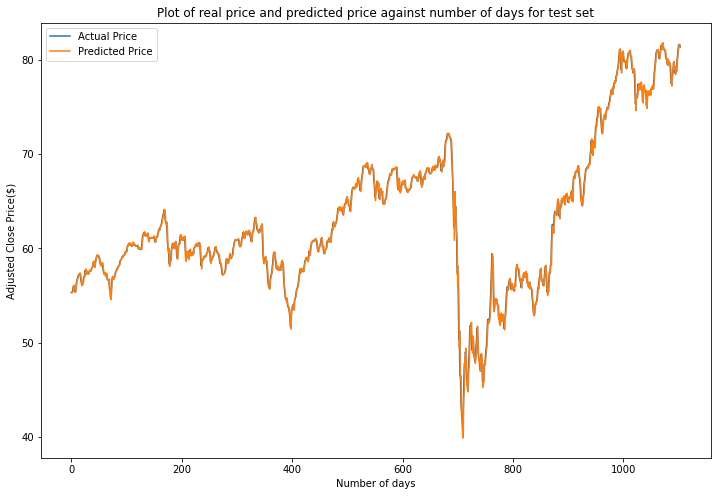

In [23]:
if __name__ == "__main__":
    #start_date = datetime(2010, 9, 1)
    #end_date = datetime(2020, 8, 31)
    

    #invoke to_csv for df dataframe object from 
    #DataReader method in the pandas_datareader library
    # df = web.DataReader("GOOGL", 'yahoo', start_date, end_date)
    
    # df.to_csv('google_stocks_data.csv')

    #pulling of google data from csv file
    stock_df = data#pd.read_csv('./stock-project/csv_files/google_stocks_data.csv')   #Note this data was pulled on 6 October 2020, some data may have changed since then 

    train_split = 0.7
    
    data_set_points = 60

    new_df = stock_df[['Adj Close']].copy()

    #Train test split

    X_train, y_train, X_test, y_test, test_data = train_test_split_preparation(new_df, data_set_points, train_split)
    
    #Training of model
    model = lstm_model(X_train, y_train, data_set_points)

    #prediction of model
    y_pred = model.predict(X_test)

    y_pred = y_pred.flatten()

    #actual represents the test set's actual stock prices
    actual = np.array([test_data['Adj Close'][i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

    #reference represents the stock price of the point before the prediction, so we can iteratively add the difference
    reference = test_data['Adj Close'][data_set_points - 1]

    predicted = []

    predicted.append(reference)

    #adding of difference and appending to the list
    for i in y_pred:
        reference += i
        predicted.append(reference)

    predicted = np.array(predicted)

    print(predicted)

#     real = plt.plot(actual, label='Actual Price')
#     pred = plt.plot(predicted, label='Predicted Price')

#     plt.legend(['Actual Price', 'Predicted Price'])
#     plt.gcf().set_size_inches(15, 10, forward=True)
    
#     plt.show()

    #Use of an algorithm to buy and sell if it exceeds the threshold
    y_pct_change, money, left = buy_sell_trades(actual, predicted)

    generate_predicted_result_based_on_previous_actual(actual, y_pred)


  

In [19]:
y_pct_change

,Predictions
0,NaN
1,0.001067
2,0.000102
3,-0.001278
4,-0.000404
...,...
1139,0.002198
1140,0.002112
1141,0.001234
1142,-0.001360


In [20]:
money

17920.419692774754

In [21]:
left

14828.352108760833

In [24]:
X_test

array([[[-1.17076427e-01],
        [ 2.36428871e-02],
        [-2.26704810e-01],
        ...,
        [ 2.59555858e-01],
        [ 1.14427581e-01],
        [ 3.99763398e-01]],

       [[ 2.36428871e-02],
        [-2.26704810e-01],
        [-2.49701908e-01],
        ...,
        [ 1.14427581e-01],
        [ 3.99763398e-01],
        [ 6.32642811e-02]],

       [[-2.26704810e-01],
        [-2.49701908e-01],
        [-1.52007866e-01],
        ...,
        [ 3.99763398e-01],
        [ 6.32642811e-02],
        [-1.45045052e-03]],

       ...,

       [[-1.28714650e-01],
        [-1.49833611e+00],
        [ 6.05916454e-01],
        ...,
        [ 5.67993284e-01],
        [ 6.27800030e-01],
        [ 6.42231002e-01]],

       [[-1.49833611e+00],
        [ 6.05916454e-01],
        [ 8.51517780e-01],
        ...,
        [ 6.27800030e-01],
        [ 6.42231002e-01],
        [ 1.33781247e-01]],

       [[ 6.05916454e-01],
        [ 8.51517780e-01],
        [-3.22040570e-01],
        ...,
        

In [ ]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price